In [20]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pickle
import joblib

In [21]:
model = pickle.load(open('/home/disk/eos9/jlu43/random_forests/model.0.8751679637015776',"rb"))

/home/disk/eos9/jlu43/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/disk/eos9/jlu43/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [22]:
#TESTING DATA 
#oc is used for UIOOPS and EOL, x_test used for model

ice_test="/home/disk/eos15/ijjhsiao/Particle_Research/data/training/ice/ice_data.test.nc"
liquid_test="/home/disk/eos9/jkcm/Data/particle/liquid/liquid_data.test.nc"

ice_testdt = xr.open_dataset(ice_test)
liquid_testdt = xr.open_dataset(liquid_test)

ice_testdt = ice_testdt.drop_dims(['bin_count', 'pos_count'])
liquid_testdt = liquid_testdt.drop_dims(['bin_count', 'pos_count'])

ice_testr = [0] * len(ice_testdt.image_length)
liquid_testr = [1] * len(liquid_testdt.image_length)
y_test = np.concatenate((np.array(ice_testr), np.array(liquid_testr)))

x_test = ice_testdt.to_dataframe().append(liquid_testdt.to_dataframe(),sort=False)

oc = x_test
oc['phase']=y_test
small_test_oc = oc.query("image_area >= 0.0025 and image_area < 0.01")
medium_test_oc = oc.query("image_area >= 0.01 and image_area < 0.07")
big_test_oc = oc.query("image_area >= 0.07")
                       
x_test=x_test.drop(['Date','Time','msec','Time_in_seconds','SliceCount', 'DMT_DOF_SPEC_OVERLOAD',
             'Particle_number_all', 'particle_time', 'particle_millisec', 'inter_arrival',
             'particle_microsec', 'parent_rec_num', 'particle_num', 'image_longest_y',
             'image_auto_reject', 'image_hollow', 'image_center_in', 'image_axis_ratio',
             'part_z', 'size_factor', 'holroyd_habit','datetime','area_hole_ratio'],axis=1)

x_test['phase']=y_test
small_test = x_test.query("image_area >= 0.0025 and image_area < 0.01")
medium_test = x_test.query("image_area >= 0.01 and image_area < 0.07")
big_test = x_test.query("image_area >= 0.07")

In [25]:
#get f1 scores for model. Run on (small_test, medium_test, big_test)

test_predictions = model.predict(small_test.drop('phase', axis=1))
classification_report(small_test.phase,test_predictions,output_dict = True)

{'0': {'precision': 0.7755310980291784,
  'recall': 0.7575,
  'f1-score': 0.7664095105602631,
  'support': 4000},
 '1': {'precision': 0.9038937877737045,
  'recall': 0.9123,
  'f1-score': 0.9080774399044443,
  'support': 10000},
 'accuracy': 0.8680714285714286,
 'macro avg': {'precision': 0.8397124429014415,
  'recall': 0.8349,
  'f1-score': 0.8372434752323537,
  'support': 14000},
 'weighted avg': {'precision': 0.8672187335609828,
  'recall': 0.8680714285714286,
  'f1-score': 0.8676008886632497,
  'support': 14000}}

In [26]:
#UIOOPS and EOL predictions

hollow=small_test_oc['image_hollow'][:]
dmax=small_test_oc['image_diam_minR'][:]*1e3 #Convert from mm to micron
holroyd=small_test_oc['holroyd_habit'][:]
area_ratio=small_test_oc['area_ratio'][:]
 
UIOOPS=np.zeros(len(hollow))
UIOOPS[np.where((hollow==1)&(dmax<300.))]=1
UIOOPS[np.where(holroyd>115)]=1
 
EOL=np.zeros(len(hollow))
EOL[np.where(area_ratio>=.5)]=1

In [27]:
#get f1 scores for UIOOPS and EOL
classification_report(UIOOPS,small_test_oc.phase,output_dict = True)
classification_report(EOL,small_test_oc.phase,output_dict = True)

#uioops small ice = 0.382
#uioops small liquid = 0.731

#uioops medium ice = 0.718
#uioops medium liquid = 0.620

#uioops large ice = 0.920
#uioops large liquid = 0.0

#eol small ice = 0.325
#eol small liquid = 0.849

#eol medium ice = 0.386
#eol medium  liquid = 0.616

#eol medium ice = 0.619
#eol medium  liquid = 0.378

{'0.0': {'precision': 0.20875,
  'recall': 0.7382847038019452,
  'f1-score': 0.3254726174235042,
  'support': 1131},
 '1.0': {'precision': 0.9704,
  'recall': 0.7540601445333748,
  'f1-score': 0.8486597577506669,
  'support': 12869},
 'accuracy': 0.7527857142857143,
 'macro avg': {'precision': 0.589575,
  'recall': 0.7461724241676599,
  'f1-score': 0.5870661875870855,
  'support': 14000},
 'weighted avg': {'precision': 0.9088695607142858,
  'recall': 0.7527857142857143,
  'f1-score': 0.8063937109142368,
  'support': 14000}}

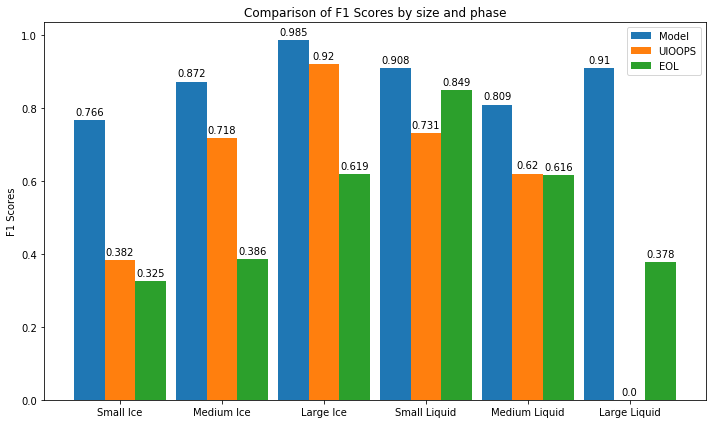

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Small Ice', 'Medium Ice', 'Large Ice', 'Small Liquid', 'Medium Liquid', 'Large Liquid']
model = [0.766, 0.872, 0.985, 0.908, 0.809, 0.910]
UIOOPS = [0.382, 0.718, 0.920, 0.731, 0.620, 0.0]
EOL = [0.325, 0.386, 0.619, 0.849, 0.616 ,0.378]


x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, model, width, label='Model')
rects2 = ax.bar(x, UIOOPS, width, label='UIOOPS')
rects3 = ax.bar(x + width, EOL, width, label='EOL')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Scores')
ax.set_title('Comparison of F1 Scores by size and phase')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.savefig("all_f1.png", dpi=400)
plt.show()